# Validation of Kriging Estimates

A validation is conducted for the ordinary Kriging method that was implemented previously. Out of 245 weather stations, 40 stations are selected by using random sampling and are kept for validation. 

The remainder of the 205 stations are used for prediction. 

Once the prediction is done, the estimate values at validation points are found and compared with the observed values. 

The error of Kriging model at each point of validation set and also overall root-mean-square error is calculated. 

The process is done for ordinary Kriging with two exponential and spherical variogram forms. 

Finally, the estimation error at each point of is visualized.

In [1]:
inLibraries = list('repr','rgdal','rgeos','gstat','sp','RColorBrewer','classInt','forecast')
for (rpack in inLibraries) {
  if (is.element(rpack,installed.packages()[,1])){           
      #Load the library into R
      suppressMessages(library(rpack,character.only = TRUE))
    }
    else {
        print(paste("Warning:  ",rpack," is not an installed package"))
    }
}
#resize plot area
options(repr.plot.width=6, repr.plot.height=6)

## Read Observed Measurements

In this practice, the primary goal is to obtain a good estimate of maximum temperature for locations in Missouri. While observations of temperature from locations solely within the state could be used, it is much better to also include observations from surrounding states as well in order to avoid edge effects. As such, we will use observations of maximum temperature at 245 weather stations over the state of Missouri and its eight surroundings states (KY,AR,IA,IL,KS,NE,OK,TN) to infer maximum temperature at locations having no weather station.

The station point locations can be found at (weatherdata/weatherdatapoints.shp) and state boundaries that can be used for spatial context can be found at (weatherdata/states_polygon.shp). The maximum temperature attribute in the station dataset is named 'highTemp' and was derived from a single day's weather information obtained from https://www.wunderground.com/.

In [2]:
# Read point data of weather station locations
inFeature.pts <- readOGR("/dsa/data/geospatial/DS8612/weatherdata","weatherdatapoints")

# Read polygon data of states boundaries
inFeature.polys <- readOGR("/dsa/data/geospatial/DS8612/weatherdata","states_polygon")

OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/weatherdata", layer: "weatherdatapoints"
with 230 features
It has 17 fields
OGR data source with driver: ESRI Shapefile 
Source: "/dsa/data/geospatial/DS8612/weatherdata", layer: "states_polygon"
with 9 features
It has 9 fields


## Sync CRS of Point and Polygon Featureclasses

If you look at the two input datasets, you'll find that they are in two different CRSs. As such, if we wish to compare or overlay these geographies, then they will need to be in the same CRS. The point data are in UTM zone 15N...let's use that CRS. Now, convert the polygon featureclass into the same CRS as the point featureclass.

In [3]:
#Get CRS of the point featureclass
ptCRS <- proj4string (inFeature.pts)

# Transform to angular system (lat/long)
inFeature.polys.UTM <- spTransform(inFeature.polys, CRS(ptCRS))

## Test for Normality and Transform Accordingly

First, test for normality of the 'highTemp' variable using a Shapiro test. The test indicates the distribution is not normal.  

As such, let's apply a Box-Cox transformation.  First, the BoxCox.lambda() function (forecast library) is used to estimate the transformation parameter. Second, the BoxCox() function (forecast library) is used to actually apply the Box-Cox transformation. Test the normality hypothesis again.  While it is still not ideal, the distributional characteristics did exhibit some improvement.

In [5]:
#test normality of original data
shapiro.test(inFeature.pts$highTemp)


	Shapiro-Wilk normality test

data:  inFeature.pts$highTemp
W = 0.97016, p-value = 9.091e-05


In [7]:
#box-cox transformation
lambda <- BoxCox.lambda(inFeature.pts$highTemp,method = "guerrero",lower=-4,upper=4) 
lambda

[1] -0.2622389

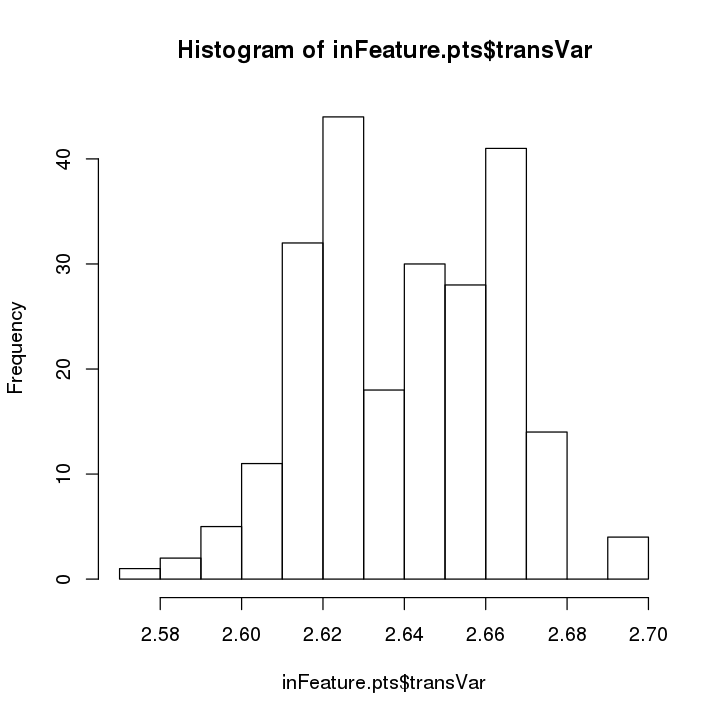

In [9]:
#apply box cox transformation to variable
inFeature.pts$transVar <- BoxCox(inFeature.pts$highTemp,lambda)

#test transformed variable
hist(inFeature.pts$transVar)

In [10]:
shapiro.test(inFeature.pts$transVar)


	Shapiro-Wilk normality test

data:  inFeature.pts$transVar
W = 0.97147, p-value = 0.000137


## Separate Data into Two Sets: a) Interpolation, and b) Validation

First, draw 40 random station locations to use to validate the results of the interpolation.

In [11]:
# Take a 40 samples from the point feature 
numsamples <- 40

#get features in dataset
dl <- length(inFeature.pts)

# Draw samples randomly
samp.rand <- inFeature.pts[sample(dl, numsamples),]

cc <- as.numeric(row.names(samp.rand))

# Select sampled points and keep them in validation set
inFeature.vld <- inFeature.pts [samp.rand,]

# Select non-sampled points and keep them for prediction
inFeature.est <- inFeature.pts [!(row.names(inFeature.pts) %in% cc),]

# Save temperature fields in new variables
invar.est <- inFeature.est$transVar
invar.vld <- inFeature.vld$transVar

### Visualize Interpolation and Validation Points

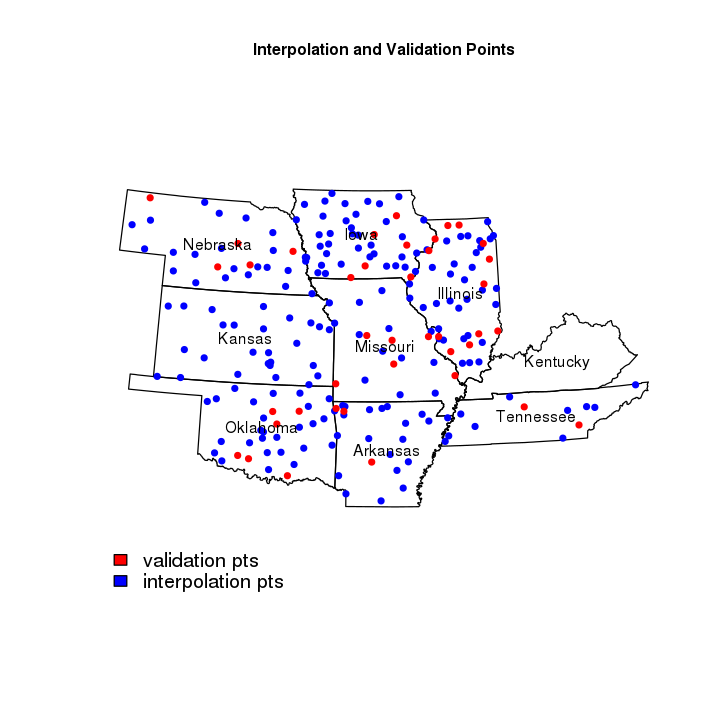

In [12]:
# Plot the states boundary 
plot(inFeature.polys.UTM,border='black', main="Interpolation and Validation Points",cex.main=.8)

# Symbolize estimation set in blue
plot(inFeature.est,col="blue", pch=20, add=TRUE)

# Symbolize validation set in red
plot(inFeature.vld,col="red", pch=20, add=TRUE)

# Get centroid of polygons
centroids <- gCentroid(inFeature.polys.UTM, byid=TRUE)
centroidLons <- coordinates(centroids)[,1]
centroidLats <- coordinates(centroids)[,2]

# Label the name of polygons
text(centroidLons, centroidLats, labels=inFeature.polys.UTM$NAME,cex=0.8)


#assign colors to categories
pal <- c("red","blue")

leg <- c("validation pts", "interpolation pts")
legend("bottomleft", fill=pal, legend=leg, bty="n")

## Create an Interpolation Grid

In order to interpolate something, a areal unit that represents the area for which a value will be interpolated is needed. Most often, interpolation techniques use raster cells as the areal unit of interpolation.  The krige() function (gstat library) requires an input grid dataframe to which to interpolate the point values. In order to create a grid that covers the study area, the extent of data should be specified. Also, the grid projection needs to be the same as input data.

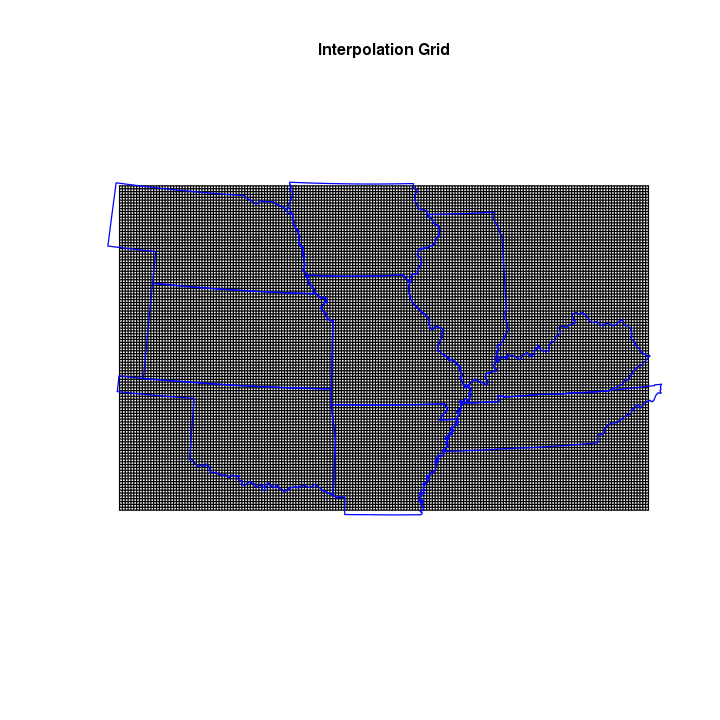

In [13]:
# create a grid object using extent of study site, lower value of cell size gives better resolution but higher computation time
grd <- expand.grid(Longitude = seq(
                                    from = min (coordinates(inFeature.pts)[,1]), 
                                    to = max (coordinates(inFeature.pts)[,1]), 
                                    by = 10000),
                   Latitude = seq(
                                   from = min (coordinates(inFeature.pts)[,2]),
                                   to = max (coordinates(inFeature.pts)[,2]), 
                                   by = 10000))

# specify the coordination system of grid object to be that of original dataset
coordinates(grd) <- ~ Longitude + Latitude

# creat a fishnet of grid object accordingly
gridded(grd) <- TRUE

# set the projection system to be that of original dataset
proj4string(grd) <- proj4string(inFeature.pts)

plot(grd, main = "Interpolation Grid", cex.main = 0.8)
plot(inFeature.polys.UTM, border = 'blue', add  =TRUE)

## Fit Variogram to Sample Observations

Here, a mathematical model is fitted to the empirical variogram using a subset of the original dataset. The empirical variogram is calculated using variogram() function (gstat package). The distances considered in the computation of the empirical variogram can be limited by the 'cutoff' parameter. Once the empirical variogram is computed, the fit.variogram() function is used to fit a theoritical model to the sample. The key parameters to fit.variogram function are a sample variogram (output of variogram function) and variogram model (output of vgm() function). The vgm() function allows the variogram characteristics (sill, range, nugget and model form (i.e. Exp, Gau, Sph, etc.) to be adjusted to improve the fit. The choice of which model form to use (i.e. Exp, Gau, Sph) depends on how one believes the covariance function decreases as distances between points increase. Let's explore the exp and sph models.

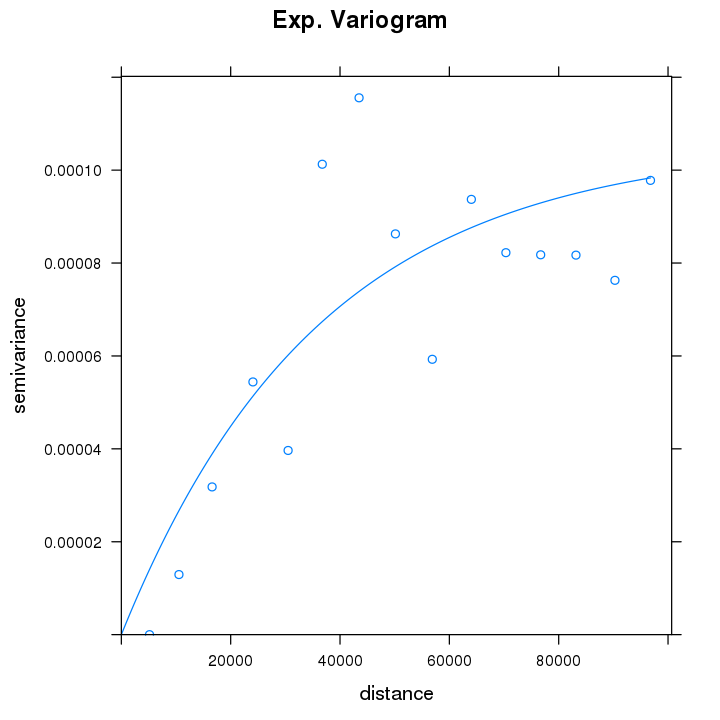

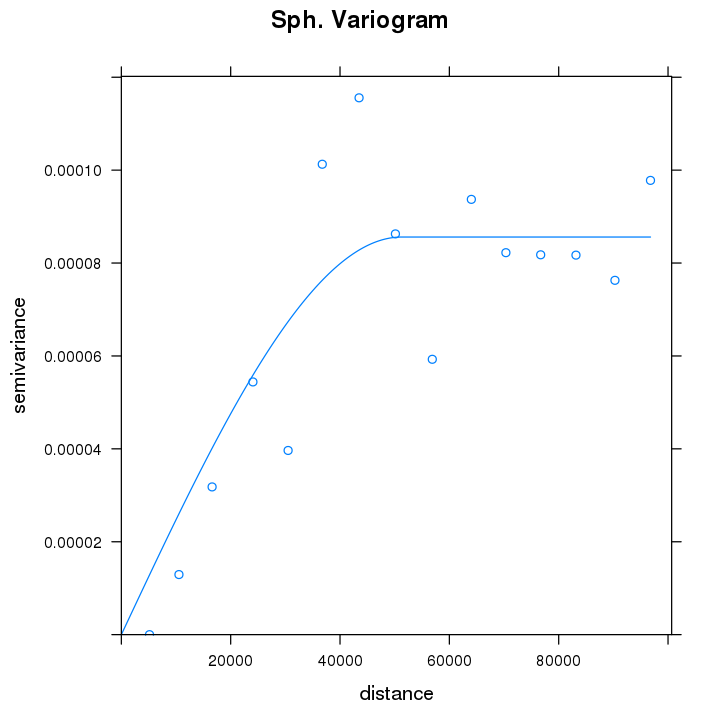

In [15]:
# Create empirical variogram
vrg <- variogram(inFeature.est$transVar ~ 1, inFeature.est, cutoff = 100000)

# Fit mathematical models (exponential and spherical) to the empirical variogram
fit.vrg.exp <- fit.variogram(vrg, 
                                 vgm(psill = 7.5, 
                                     "Exp", 
                                     range = 40000, 
                                     nugget = 0))

fit.vrg.sph <- fit.variogram(vrg, 
                                 vgm(psill = 7.5, 
                                     "Sph", 
                                     range = 40000, 
                                     nugget = 0))

#plot variograms
plot(vrg, fit.vrg.exp, main = "Exp. Variogram", cex.main = 0.8)

plot(vrg, fit.vrg.sph, main = "Sph. Variogram", cex.main = 0.8)

## Implement Kriging

Once the variogram is fitted to the sample, the krige() (gstat library) can be used to conduct ordinary Kriging as below. The Kriging method gives prediction values and their variance as measure of accuracy. 

Remember that earlier the observed temperature values were transformed to help improve normality. However, those transformed values are less intuitive to interpret. Therefore, to better visualize the predicted values, a backtransformation needs to be applied. Here, the InvBoxCox() function (forecast library) is applied to do the backtransformation given that the BoxCox transformation was applied earlier. 

Note, in order to classify the predicted values using classIntervals(), they are first converted into a vector, then backtransformed. Then a new attribute is added to the spatialpixel dataframe to store the backtransformed variable.

As can be seen from the second plot below, the estimation variance increases towards the edges since less observations are used for prediction on periphery of study area.

In [16]:
# Implement ordinary Kriging and make the prediction
ok.exp <- krige(inFeature.est$transVar ~ 1, inFeature.est, grd, fit.vrg.exp)
ok.sph <- krige(inFeature.est$transVar ~ 1, inFeature.est, grd, fit.vrg.sph)

[using ordinary kriging]
[using ordinary kriging]


## Find estimate values at validation points

Now that predicted values have been added to the grid dataframe, we need to extract estimate values for our validation points. 

To do so, the over() function (rgeos library) is used. 

This procedure essentially associates each of the validation points with the kriging prediction and variance for both the exponential and spherical models.  

However, to formally associate the point dataframe with the overlay results, you'll need to bind the overlay output to the dataframe using cbind().  

Then, you can rename the added variables accordingly.  In the end, you'll see that four fields are added to validation data table (two fields for the exponential and two for the spherical model).

In [23]:
# Overlay validation set over prediction grid
pred.exp <- over(inFeature.vld, ok.exp)
pred.sph <- over(inFeature.vld, ok.sph)

In [26]:
head(inFeature.vld)

            coordinates state                  city day month year period
1   (473932.7, 4539913)    IA              Chariton  13     7 2017      1
7  (-317630.9, 4790702)    NE               Chadron  13     7 2017      1
10  (395687.5, 4004537)    AR            Springdale  13     7 2017      1
11  (892426.1, 4289819)    IL                 Flora  13     7 2017      1
13  (498164.2, 3817597)    AR Hot Springs Natl Park  13     7 2017      1
21  (931575.6, 4564827)    IL              Kankakee  13     7 2017      1
   highTemp lowTemp               conditions qpf_allday snow_allda avewindSpe
1        82      61            Partly Cloudy       0.00          0          0
7        92      63                    Clear       0.00          0          3
10       92      71            Partly Cloudy       0.00          0          0
11       93      72 Chance of a Thunderstorm       1.03          0          6
13       94      75 Chance of a Thunderstorm       0.10          0          2
21       82   

In [27]:
ok.exp[1:5, ]

Object of class SpatialPixelsDataFrame
Object of class SpatialPixels
Grid topology:
          cellcentre.offset cellsize cells.dim
Longitude         -384202.2    10000       186
Latitude          3674622.4    10000       114
SpatialPoints:
  Longitude Latitude
1 -384202.2  3674622
2 -374202.2  3674622
3 -364202.2  3674622
4 -354202.2  3674622
5 -344202.2  3674622
Coordinate Reference System (CRS) arguments: +proj=utm +zone=15
+datum=NAD83 +units=m +no_defs +ellps=GRS80 +towgs84=0,0,0 

Data summary:
   var1.pred       var1.var        
 Min.   :2.64   Min.   :0.0001066  
 1st Qu.:2.64   1st Qu.:0.0001066  
 Median :2.64   Median :0.0001066  
 Mean   :2.64   Mean   :0.0001066  
 3rd Qu.:2.64   3rd Qu.:0.0001066  
 Max.   :2.64   Max.   :0.0001066  

In [21]:
pred.exp[1:5, ]

,var1.pred,var1.var
1,2.625754,8.707406e-05
7,2.639044,1.054551e-04
10,2.658187,4.126102e-05
11,2.644073,8.710455e-05
13,2.645854,1.036210e-04


In [22]:
pred.sph[1:5, ]

,var1.pred,var1.var
1,2.635380,8.264139e-05
7,2.639049,8.610242e-05
10,2.659119,3.998748e-05
11,2.639788,8.514379e-05
13,2.639049,8.610242e-05


In [28]:
#bind overlay results with validation points
inFeature.vld@data <- cbind(inFeature.vld@data, pred.exp)

head(inFeature.vld@data)

,state,city,day,month,year,period,highTemp,lowTemp,conditions,qpf_allday,⋯,avehumidit,Longi,Lati,transVar,pred.exp,var.exp,pred.sph,var.sph,var1.pred,var1.var
1,IA,Chariton,13,7,2017,1,82,61,Partly Cloudy,0.00,⋯,81,-93.31,41.01,2.612639,2.625754,8.707406e-05,2.635380,8.264139e-05,2.625754,8.707406e-05
7,NE,Chadron,13,7,2017,1,92,63,Clear,0.00,⋯,55,-103.00,42.83,2.648329,2.639044,1.054551e-04,2.639049,8.610242e-05,2.639044,1.054551e-04
10,AR,Springdale,13,7,2017,1,92,71,Partly Cloudy,0.00,⋯,85,-94.16,36.18,2.648329,2.658187,4.126102e-05,2.659119,3.998748e-05,2.658187,4.126102e-05
11,IL,Flora,13,7,2017,1,93,72,Chance of a Thunderstorm,1.03,⋯,90,-88.49,38.67,2.651627,2.644073,8.710455e-05,2.639788,8.514379e-05,2.644073,8.710455e-05
13,AR,Hot Springs Natl Park,13,7,2017,1,94,75,Chance of a Thunderstorm,0.10,⋯,93,-93.02,34.50,2.654881,2.645854,1.036210e-04,2.639049,8.610242e-05,2.645854,1.036210e-04
21,IL,Kankakee,13,7,2017,1,82,64,Partly Cloudy,0.00,⋯,88,-87.86,41.12,2.612639,2.629655,9.838825e-05,2.639049,8.610242e-05,2.629655,9.838825e-05


In [29]:
#modify the new field names
names(inFeature.vld@data)[names(inFeature.vld@data) == "var1.pred"] <- "pred.exp"
names(inFeature.vld@data)[names(inFeature.vld@data) == "var1.var"] <- "var.exp"

In [30]:
#bind overlay results with validation points
inFeature.vld@data <- cbind(inFeature.vld@data,pred.sph)

#modify the new field names
names(inFeature.vld@data)[names(inFeature.vld@data) == "var1.pred"] <- "pred.sph"
names(inFeature.vld@data)[names(inFeature.vld@data) == "var1.var"] <- "var.sph"
head(inFeature.vld@data)

,state,city,day,month,year,period,highTemp,lowTemp,conditions,qpf_allday,⋯,Lati,transVar,pred.exp,var.exp,pred.sph,var.sph,pred.exp.1,var.exp.1,pred.sph.1,var.sph.1
1,IA,Chariton,13,7,2017,1,82,61,Partly Cloudy,0.00,⋯,41.01,2.612639,2.625754,8.707406e-05,2.635380,8.264139e-05,2.625754,8.707406e-05,2.635380,8.264139e-05
7,NE,Chadron,13,7,2017,1,92,63,Clear,0.00,⋯,42.83,2.648329,2.639044,1.054551e-04,2.639049,8.610242e-05,2.639044,1.054551e-04,2.639049,8.610242e-05
10,AR,Springdale,13,7,2017,1,92,71,Partly Cloudy,0.00,⋯,36.18,2.648329,2.658187,4.126102e-05,2.659119,3.998748e-05,2.658187,4.126102e-05,2.659119,3.998748e-05
11,IL,Flora,13,7,2017,1,93,72,Chance of a Thunderstorm,1.03,⋯,38.67,2.651627,2.644073,8.710455e-05,2.639788,8.514379e-05,2.644073,8.710455e-05,2.639788,8.514379e-05
13,AR,Hot Springs Natl Park,13,7,2017,1,94,75,Chance of a Thunderstorm,0.10,⋯,34.50,2.654881,2.645854,1.036210e-04,2.639049,8.610242e-05,2.645854,1.036210e-04,2.639049,8.610242e-05
21,IL,Kankakee,13,7,2017,1,82,64,Partly Cloudy,0.00,⋯,41.12,2.612639,2.629655,9.838825e-05,2.639049,8.610242e-05,2.629655,9.838825e-05,2.639049,8.610242e-05


In [31]:
inFeature.vld@data$btpred.exp <- InvBoxCox(inFeature.vld@data$pred.exp, lambda)
inFeature.vld@data$btpred.sph <- InvBoxCox(inFeature.vld@data$pred.sph, lambda)
head(inFeature.vld@data)

,state,city,day,month,year,period,highTemp,lowTemp,conditions,qpf_allday,⋯,pred.exp,var.exp,pred.sph,var.sph,pred.exp.1,var.exp.1,pred.sph.1,var.sph.1,btpred.exp,btpred.sph
1,IA,Chariton,13,7,2017,1,82,61,Partly Cloudy,0.00,⋯,2.625754,8.707406e-05,2.635380,8.264139e-05,2.625754,8.707406e-05,2.635380,8.264139e-05,85.50733,88.20265
7,NE,Chadron,13,7,2017,1,92,63,Clear,0.00,⋯,2.639044,1.054551e-04,2.639049,8.610242e-05,2.639044,1.054551e-04,2.639049,8.610242e-05,89.25680,89.25805
10,AR,Springdale,13,7,2017,1,92,71,Partly Cloudy,0.00,⋯,2.658187,4.126102e-05,2.659119,3.998748e-05,2.658187,4.126102e-05,2.659119,3.998748e-05,95.03020,95.32291
11,IL,Flora,13,7,2017,1,93,72,Chance of a Thunderstorm,1.03,⋯,2.644073,8.710455e-05,2.639788,8.514379e-05,2.644073,8.710455e-05,2.639788,8.514379e-05,90.72954,89.47270
13,AR,Hot Springs Natl Park,13,7,2017,1,94,75,Chance of a Thunderstorm,0.10,⋯,2.645854,1.036210e-04,2.639049,8.610242e-05,2.645854,1.036210e-04,2.639049,8.610242e-05,91.25855,89.25805
21,IL,Kankakee,13,7,2017,1,82,64,Partly Cloudy,0.00,⋯,2.629655,9.838825e-05,2.639049,8.610242e-05,2.629655,9.838825e-05,2.639049,8.610242e-05,86.58679,89.25805


To make things easier to see, create an array that just contains the variable to be interpolated and the predicted values for each model.

In [ ]:
# Create an array object for calculating RMSE
data.array <- inFeature.vld@data[ , 
                                    c("highTemp", "pred.exp$pred.exp", "pred.exp$var.exp", 
                                      "pred.sph$pred.sph", "pred.sph$var.sph")
                                ]

# Show real and estimate values (pred &var) for both models (exp & sph)
data.array

## Calculate Error (Difference between observed and predicted)

Using the observed and backtransformed estimated values, the difference between the validation point values and the predicted values (generated based on the subset of points) can be calculated as below. New fields are added to the dataframe to store error info.

In [43]:
inFeature.vld@data$highTemp[1:5]

[1] 82 92 92 93 94

In [44]:
inFeature.vld@data$btpred.exp[1:5]

[1] 85.50733 89.25680 95.03020 90.72954 91.25855

In [45]:
inFeature.vld@data$btpred.sph[1:5]

[1] 88.20265 89.25805 95.32291 89.47270 89.25805

In [47]:
# Add an error field for each model (will be used later for visualization)
inFeature.vld@data$error.exp <- inFeature.vld@data$highTemp - inFeature.vld@data$btpred.exp
inFeature.vld@data$error.sph <- inFeature.vld@data$highTemp - inFeature.vld@data$btpred.sph

In [49]:
inFeature.vld@data$error.exp[1:5]

[1] -3.507334  2.743200 -3.030199  2.270460  2.741449

### Root-Mean-Square Error (RSME)

Given the error between the validation points and estimated values has been computed, RMSE can be assessed for the exponential and spherical model forms.

In [50]:
# RMSE for exponential model
rmsee.exp <- (mean((inFeature.vld@data$highTemp - inFeature.vld@data$btpred.exp)^2))^0.5

# Print RSME for exp model
print("RMSE for exponential model")
rmsee.exp

[1] "RMSE for exponential model"


[1] 3.890515

In [51]:
# RMSE for spherical model
rmsee.sph <- (mean((inFeature.vld@data$highTemp - inFeature.vld@data$btpred.sph)^2))^0.5

# Print RSME for spherical model
print ("RMSE for spherical model")
rmsee.sph

[1] "RMSE for spherical model"


[1] 6.407883

## Visualize Estimated Error

Test the distribution of estimation error using the Shapiro test for each kriging model.

### Exponential Model

The Shapiro test indicates that the distribution of errors are normal.  In the map, the positive values indicate overstimation and negative values indicate underestimation. Note that in many instances, the most severe over and under estimation occurs at the periphery of the study area...something known as 'edge effects'. The reason behind this is that we selectively excluded weather data outside of the study area and as such, locations at the edge of the study area will be interpolated based on less information.

In [54]:
#test the errors for normality
shapiro.test(inFeature.vld@data$error.exp)


	Shapiro-Wilk normality test

data:  inFeature.vld@data$error.exp
W = 0.98158, p-value = 0.7479


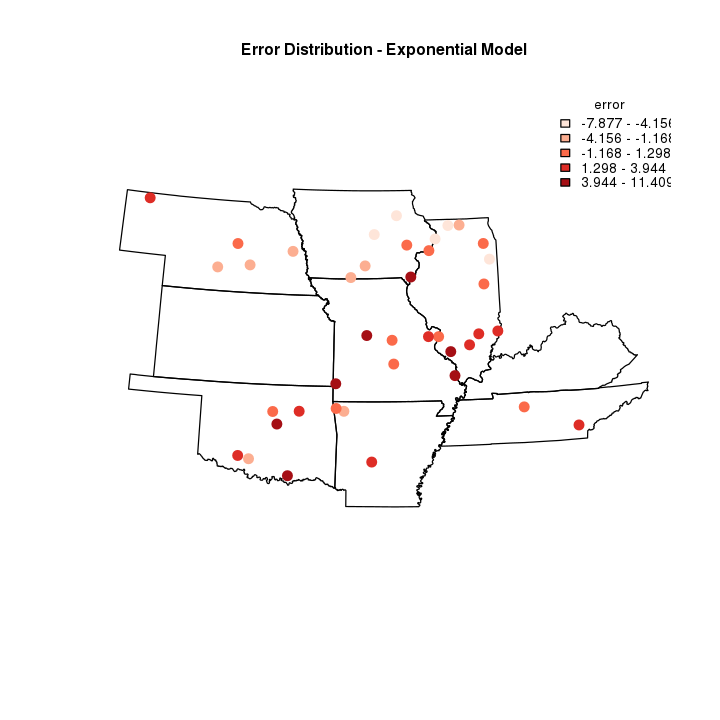

In [55]:
# Define number of classes and classification method
numcat <- 5
q <- classIntervals(inFeature.vld@data$error.exp, numcat, style = "kmeans")

# Define number of color symbols
pal <- brewer.pal(5, "Reds")

# Match color symbols with class intervals
cols <- findColours(q, pal)

# Add the boundary to previous plot
plot (inFeature.polys.UTM, main = "Error Distribution - Exponential Model", cex.main = 0.8)

# Plot the point feature
plot(inFeature.vld, col = cols, pch = 20, lwd = 4, add = TRUE)

# Create the legend object
brks <- round(q$brks,3)

leg <- paste(brks[-6], brks[-1], sep=" - ")

legend("topright", fill = pal, legend = leg, bty = "n", title = "error", cex = 0.7)

### Spherical Model

The Shapiro test indicates that the distribution of errors are normal.  In the map, the positive values indicate overstimation and negative values indicate underestimation. Note that in many instances, the most severe over and under estimation occurs at the periphery of the study area...something known as 'edge effects'. The reason behind this is that we selectively excluded weather data outside of the study area and as such, locations at the edge of the study area will be interpolated based on less information.

In [56]:
#test normality of errors
shapiro.test(inFeature.vld@data$error.sph)


	Shapiro-Wilk normality test

data:  inFeature.vld@data$error.sph
W = 0.96821, p-value = 0.3154


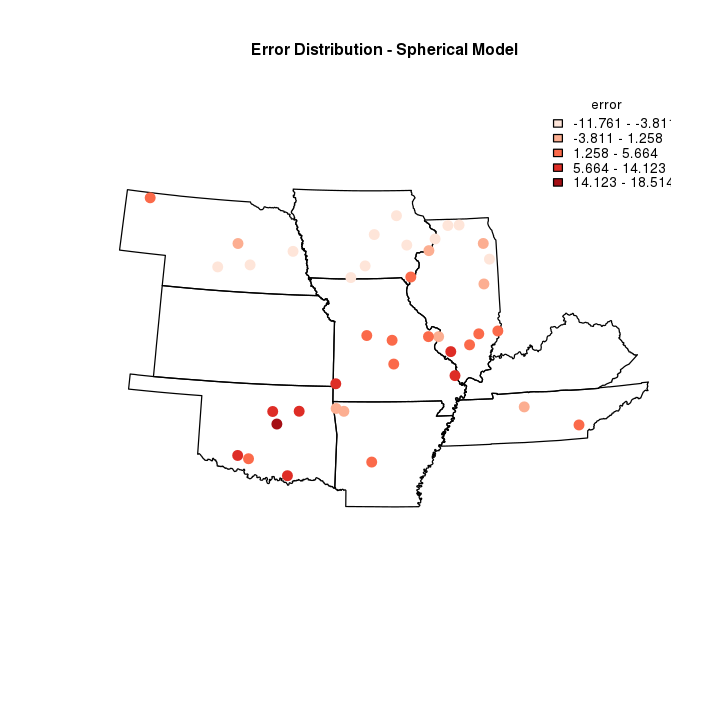

In [57]:
# Define number of classes and classification method
numcat <- 5
q <- classIntervals(inFeature.vld@data$error.sph, numcat, style = "kmeans")

# Define number of color symbols
pal <- brewer.pal(5, "Reds")
# Match color symbols with class intervals
cols <- findColours(q, pal)

# Add the boundary 
plot (inFeature.polys.UTM, main = "Error Distribution - Spherical Model", cex.main = 0.8)
# Plot the point feature
plot(inFeature.vld, col = cols, pch = 20, lwd = 4, add = TRUE)

# Create the legend object
brks <- round(q$brks,3)
leg <- paste(brks[-6], brks[-1], sep=" - ")
legend("topright", fill = pal, legend = leg, bty = "n", title = "error", cex = 0.7)